### Required Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, LeakyReLU, Reshape, TimeDistributed, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
KAGGLE_INPUT_DIR = '/kaggle/input/capstone' 
KAGGLE_WORKING_DIR = '/kaggle/working/'

EDA_DATA_FILE = os.path.join(KAGGLE_INPUT_DIR, 'DT1.csv')

dt = pd.read_csv(EDA_DATA_FILE)
dt['Time'] = pd.to_datetime(dt['Time'], format='%d-%m-%Y %H:%M')
dt.set_index('Time', inplace=True)
dt.sort_index(inplace=True)
print("EDA data loaded successfully.")
print("\nData Head:")
print(dt.head())


EDA data loaded successfully.

Data Head:
                          PM2.5
Time                           
2023-11-10 00:30:00  166.644363
2023-11-10 01:30:00  169.466324
2023-11-10 02:30:00  170.682999
2023-11-10 03:30:00  176.888916
2023-11-10 04:30:00  159.220032


<Axes: xlabel='Time'>

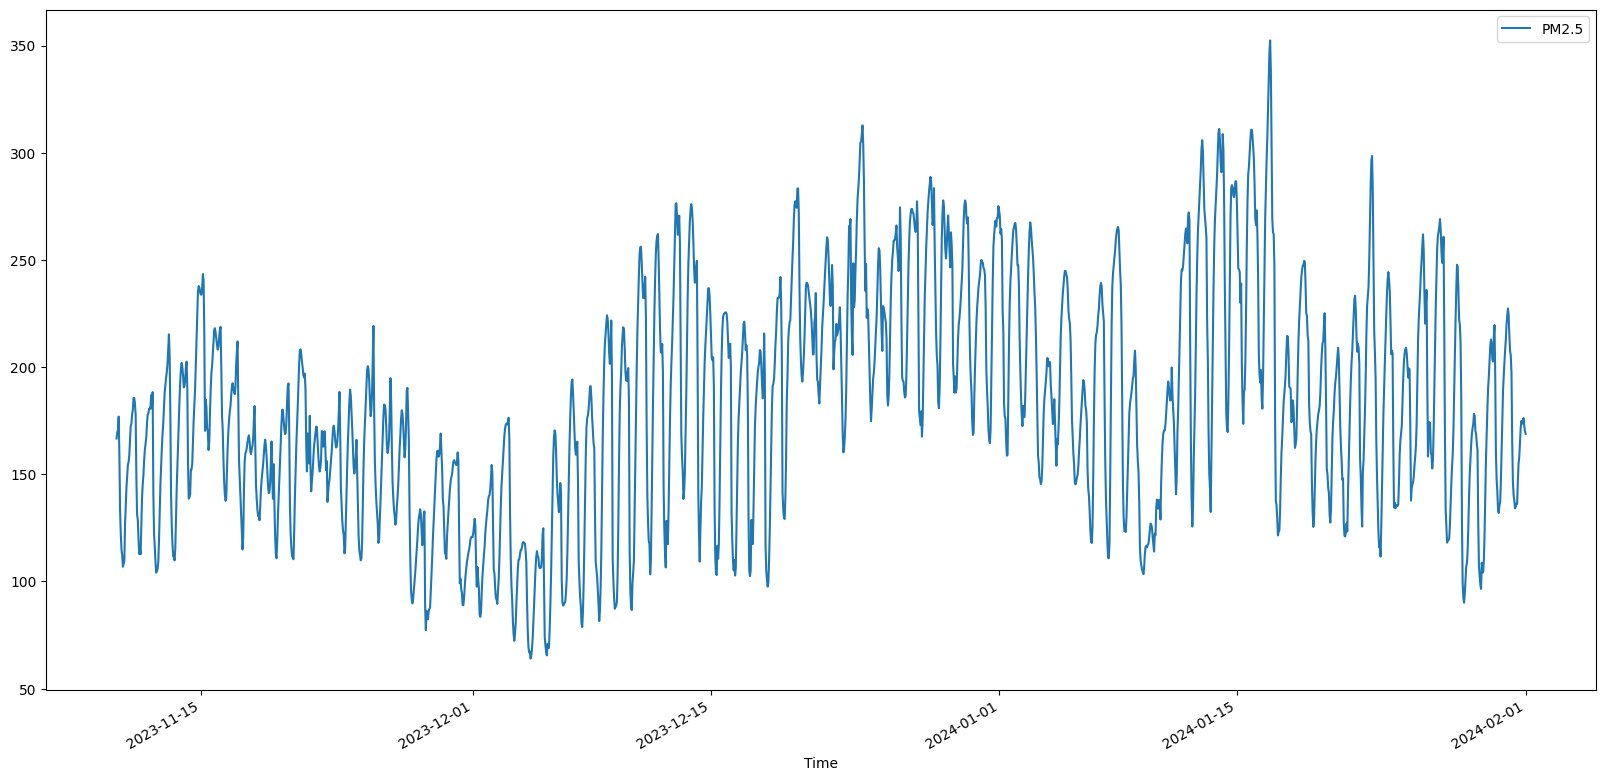

In [4]:
dt.plot(figsize=(20,10))

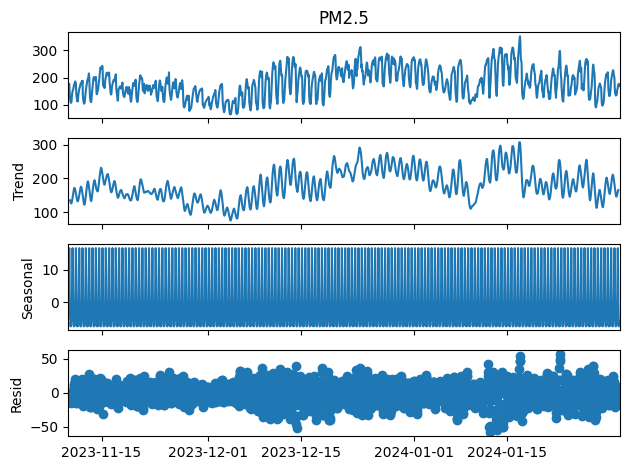

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
dt_cleaned = dt.dropna()
results = seasonal_decompose(dt_cleaned[dt_cleaned.columns[0]],period = 12)
results.plot();

In [6]:
dt.describe()


,PM2.5
count,1992.000000
mean,182.372476
std,53.397346
min,63.966141
25%,141.269649
50%,179.565483
75%,220.375797
max,352.367432


In [7]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1992 entries, 2023-11-10 00:30:00 to 2024-01-31 23:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   1992 non-null   float64
dtypes: float64(1)
memory usage: 31.1 KB


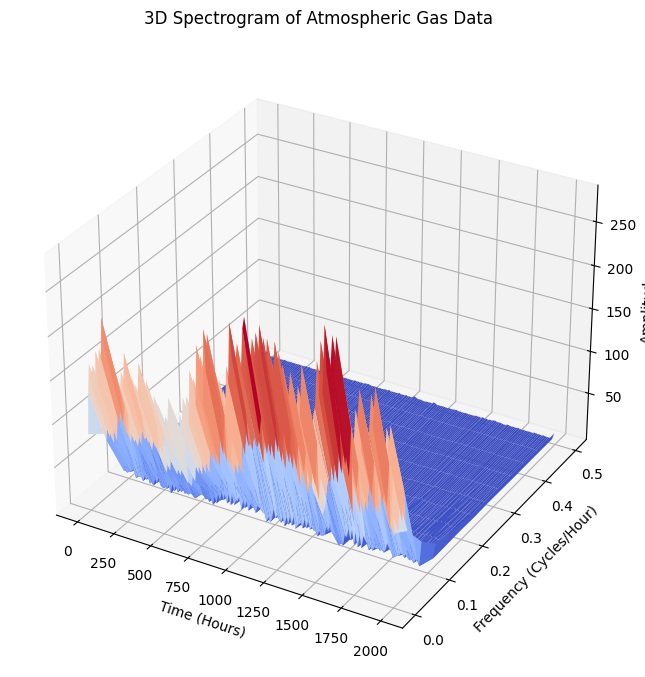

In [8]:
from scipy import signal
time_series = dt[dt.columns[0]].values
fs = 1
frequencies, times, Zxx = signal.stft(time_series, fs=fs, nperseg=24)
times_grid, frequencies_grid = np.meshgrid(times, frequencies)
amplitude = np.abs(Zxx)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(times_grid, frequencies_grid, amplitude,
                cmap=plt.cm.coolwarm, rstride=1, cstride=1)

ax.set_title('3D Spectrogram of Atmospheric Gas Data', pad=20)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Frequency (Cycles/Hour)')
ax.set_zlabel('Amplitude')

plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(dt_cleaned[dt_cleaned.columns[0]])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))
if adf_test[1] <= 0.05:
    print("Reject the null hypothesis (H0), the time series is stationary.")
else:
    print("Fail to reject the null hypothesis (H0), the time series is non-stationary.")

ADF Statistic: -3.374136
p-value: 0.011873
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Reject the null hypothesis (H0), the time series is stationary.


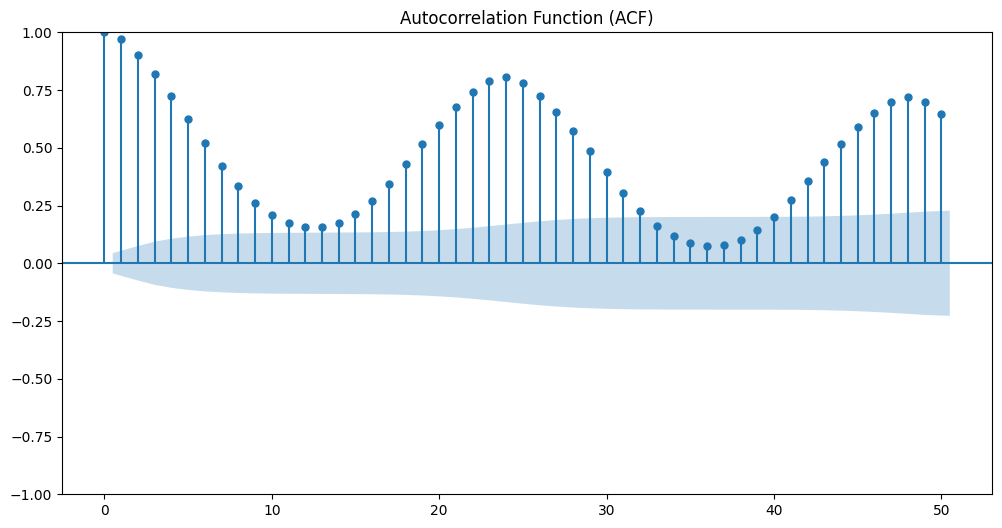

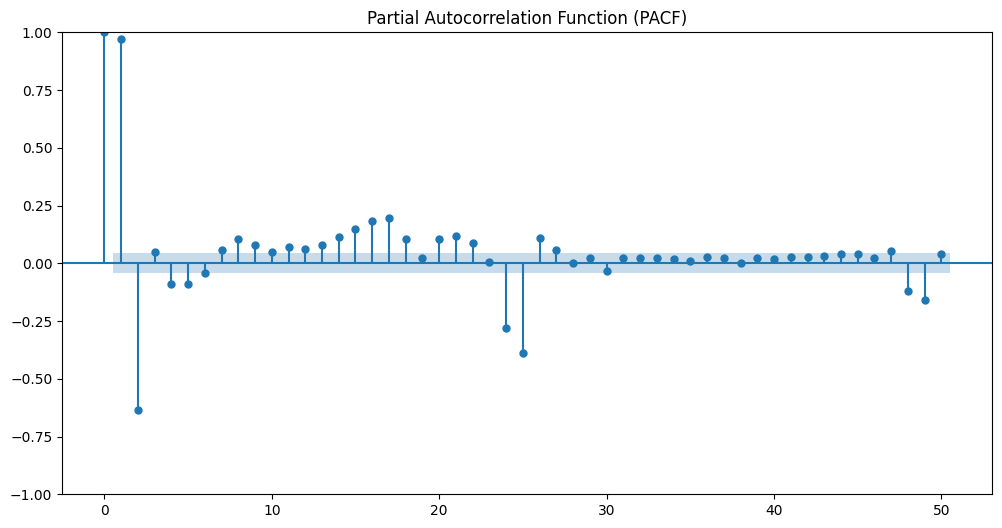

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#autocorrelation function (ACF)
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(dt_cleaned[dt_cleaned.columns[0]], ax=ax, lags=50)
ax.set_title('Autocorrelation Function (ACF)')
plt.show()
# partial autocorrelation function (PACF)
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(dt_cleaned[dt_cleaned.columns[0]], ax=ax, lags=50)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.show()

### Model Creation

In [11]:
SEQ_LENGTH = 24
LATENT_DIM = 100
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0002
BETA_1 = 0.5

In [12]:
DATA_FILE = os.path.join(KAGGLE_INPUT_DIR, 'DT1.csv')
GENERATOR_FILE = os.path.join(KAGGLE_WORKING_DIR, 'generator.h5')
DISCRIMINATOR_FILE = os.path.join(KAGGLE_WORKING_DIR, 'discriminator.h5')
SCALER_FILE = os.path.join(KAGGLE_WORKING_DIR, 'scaler.pkl')
OUTPUT_PLOT = os.path.join(KAGGLE_WORKING_DIR, 'anomaly_detection_plot.png')

print(f"Data input path set to: {DATA_FILE}")
print(f"Model output path set to: {KAGGLE_WORKING_DIR}")

Data input path set to: /kaggle/input/capstone/DT1.csv
Model output path set to: /kaggle/working/


In [13]:
def load_and_preprocess_data(filepath, seq_length):
    print(f"Loading data from {filepath}...")
    data = dt['PM2.5'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(data)
    sequences = []
    for i in range(len(data_scaled) - seq_length + 1):
        sequences.append(data_scaled[i:i + seq_length])

    if not sequences:
        print("Error: Not enough data to create sequences. Need at least {seq_length} data points.")
        return None, None, None

    X_train = np.array(sequences)
    print(f"Data shape after sequencing: {X_train.shape}")

    return X_train, data[seq_length-1:], scaler

In [14]:
def generator(latent_dim, seq_length):
    model = tf.keras.Sequential(name="Generator")

    model.add(Dense(seq_length * 64, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((seq_length, 64)))

    model.add(LSTM(128, return_sequences=True))
    model.add(LeakyReLU(alpha=0.2))
    model.add(TimeDistributed(Dense(1, activation='tanh')))

    noise = Input(shape=(latent_dim,))
    fake_seq = model(noise)

    return Model(noise, fake_seq)

In [15]:
def discriminator(seq_length):
    model = tf.keras.Sequential(name="Discriminator")

    model.add(LSTM(128, input_shape=(seq_length, 1), return_sequences=True))
    model.add(LeakyReLU(alpha=0.2))

    model.add(LSTM(64))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(1, activation='sigmoid'))

    seq = Input(shape=(seq_length, 1))
    validity = model(seq)

    return Model(seq, validity)

In [16]:

def build_combined_model(generator, discriminator, latent_dim):
    discriminator.trainable = False

    z = Input(shape=(latent_dim,))
    fake_seq = generator(z)
    validity = discriminator(fake_seq)

    combined = Model(z, validity)

    return combined

In [17]:
def train_gan(data_path, seq_length, latent_dim, epochs, batch_size):
    X_train, _, scaler = load_and_preprocess_data(data_path, seq_length)
    if X_train is None:
        return
    optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)
    d_model = discriminator(seq_length)
    d_model.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    generator_model = generator(latent_dim, seq_length)
    combined = build_combined_model(generator_model, d_model, latent_dim)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    print("Starting GAN training...")
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_seqs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_seqs = generator_model.predict(noise)
        d_loss_real = d_model.train_on_batch(real_seqs, real_labels)
        d_loss_fake = d_model.train_on_batch(fake_seqs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = combined.train_on_batch(noise, real_labels)
        if (epoch + 1) % (epochs // 20) == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc: {d_loss[1]*100:.2f}%] [G loss: {g_loss:.4f}]")

    print("Training complete.")
    generator_model.save(GENERATOR_FILE)
    d_model.save(DISCRIMINATOR_FILE)
    joblib.dump(scaler, SCALER_FILE)

    print(f"Models saved to {GENERATOR_FILE}, {DISCRIMINATOR_FILE}")
    print(f"Scaler saved to {SCALER_FILE}")

In [18]:
@tf.function
def find_best_latent_vector(generator, target_sequence, latent_dim, steps=200, lr=0.01):
    
    z = tf.Variable(tf.random.normal(shape=(1, latent_dim)))
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    loss_fn = tf.keras.losses.MeanSquaredError()

    for _ in tf.range(steps):
        with tf.GradientTape() as tape:
            generated_sequence = generator(z, training=False)
            loss = loss_fn(target_sequence, generated_sequence)

        gradients = tape.gradient(loss, [z])
        optimizer.apply_gradients(zip(gradients, [z]))
    best_generated_seq = generator(z, training=False)
    final_loss = loss_fn(target_sequence, best_generated_seq)
    return final_loss

In [19]:
def detect_anomalies(data_path, seq_length, latent_dim, alpha=0.9):
    print("--- Starting Anomaly Detection ---")
    print("Loading models and scaler...")
    try:
        generator = tf.keras.models.load_model(GENERATOR_FILE)
        discriminator_model = tf.keras.models.load_model(DISCRIMINATOR_FILE)
        scaler = joblib.load(SCALER_FILE)
    except (IOError, ImportError) as e:
        print(f"Error loading models. Have you trained them first? Run train_gan().")
        print(f"Details: {e}")
        return

    X_eval, original_data_points, _ = load_and_preprocess_data(data_path, seq_length)
    if X_eval is None:
        return

    print(f"Calculating anomaly scores for {X_eval.shape[0]} sequences...")
    anomaly_scores = []

    # Use tqdm for a progress bar (this will be slow!)
    for seq in tqdm(X_eval, desc="Scoring sequences"):
        target_seq_tensor = tf.convert_to_tensor(seq.reshape(1, seq_length, 1), dtype=tf.float32)
        reconstruction_error = find_best_latent_vector(
            generator, target_seq_tensor, latent_dim
        ).numpy()
        discriminator_output = discriminator_model(target_seq_tensor, training=False).numpy()[0][0]
        discriminator_score = 1.0 - discriminator_output

        combined_score = (alpha * reconstruction_error) + ((1 - alpha) * discriminator_score)

        anomaly_scores.append(combined_score)

    anomaly_scores = np.array(anomaly_scores)

    print(f"\nAverage anomaly score: {np.mean(anomaly_scores):.4f}")
    print(f"Median anomaly score:  {np.median(anomaly_scores):.4f}")
    print(f"Max anomaly score:     {np.max(anomaly_scores):.4f}")

    # --- Plot Results ---
    print(f"Generating plot and saving to {OUTPUT_PLOT}...")

    fig, ax1 = plt.subplots(figsize=(18, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('PM2.5 Mean', color=color)
    ax1.plot(np.arange(len(original_data_points)), original_data_points, color=color, label='PM2.5 Mean', alpha=0.8)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Anomaly Score (Combined)', color=color)
    # Align scores with the data points
    score_indices = np.arange(len(anomaly_scores))
    ax2.plot(score_indices, anomaly_scores, color=color, label='Anomaly Score', alpha=0.9)
    ax2.tick_params(axis='y', labelcolor=color)

    threshold = np.percentile(anomaly_scores, 95)
    ax2.axhline(y=threshold, color='orange', linestyle='--', label=f'95th Percentile ({threshold:.3f})')

    anomalies_indices = np.where(anomaly_scores > threshold)[0]
    # Map anomaly indices to the original data points indices
    
    ax1.scatter(anomalies_indices, original_data_points[anomalies_indices], color='red', s=50, label='Anomaly Detected')

    fig.tight_layout()
    plt.title('PM2.5 Sensor Anomaly Detection using GAN')
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.savefig(OUTPUT_PLOT)
    plt.close()

    print("--- Anomaly Detection Complete ---")

In [20]:
def main():
    # --- 1. Train the Model ---
    if not os.path.exists(GENERATOR_FILE):
        print("No trained model found. Starting training...")
        train_gan(
            data_path=DATA_FILE,
            seq_length=SEQ_LENGTH,
            latent_dim=LATENT_DIM,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE
        )
    else:
        print(f"Found existing model '{GENERATOR_FILE}'. Skipping training.")
        print("To re-train, delete the .h5 and .pkl files and run again.")


    # --- 2. Detect Anomalies in the Original Data ---
    print("\n--- Running detection on original data ---")

    # This helps the custom gradient loop in 'find_best_latent_vector'
    tf.config.run_functions_eagerly(True)

    detect_anomalies(
        data_path=DATA_FILE,
        seq_length=SEQ_LENGTH,
        latent_dim=LATENT_DIM,
        alpha=0.9  # 90% weight on reconstruction, 10% on discriminator
    )

if __name__ == "__main__":
    main()

No trained model found. Starting training...
Loading data from /kaggle/input/capstone/DT1.csv...
Data shape after sequencing: (1969, 24, 1)


I0000 00:00:1762481352.171788      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=act

Starting GAN training...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step 


I0000 00:00:1762481354.214571     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/50 [D loss: 0.6929, acc: 38.67%] [G loss: 0.6925]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 2/50 [D loss: 0.6931, acc: 29.62%] [G loss: 0.6924]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 4/50 [D loss: 0.6932, acc: 28.46%] [G loss: 0.6922]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 6/50 [D loss: 0.6934, acc: 26.27%] [G loss: 0.6919]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 8/50 [D loss: 0.6936, acc: 24.72%] [G loss: 0.6916]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 10/50 [D loss: 0.6938, acc: 24.46%] [G loss: 0.6914]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 12/50 [D loss: 0.6939, acc: 23.95%] [G loss: 0.6911]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 14/50 [D loss: 0.6941, acc: 23.81%] [G loss: 0.6908]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2

Scoring sequences: 100%|██████████| 1969/1969 [9:10:39<00:00, 16.78s/it]  



Average anomaly score: 0.3681
Median anomaly score:  0.3321
Max anomaly score:     1.1715
Generating plot and saving to /kaggle/working/anomaly_detection_plot.png...
--- Anomaly Detection Complete ---
